In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.dates as mdates

In [2]:
# local libraries
from glofrim import PCR_model, CMF_model, DFM_model
from glofrim.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
in_dir = options['GENERAL']['inputDir']
out_dir = options['GENERAL']['outputDir'] + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(in_dir)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(in_dir, options['hydrologic_model']['config_file'])
PCR_in_dir = os.path.join(os.path.dirname(PCR_config_fn), 'input30min')
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/input30min
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = options['CMF_engine']['CMF_path']
print(CMF_engine)
CMF_config_fn = os.path.join(in_dir, options['routing_model']['model_file'])
CMF_model_dir = os.path.dirname(CMF_config_fn)
CMF_out_dir = os.path.join(out_dir, 'CMF')
print(CMF_out_dir)
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/jannis/Programmes/cama-flood_bmi_v3.6.2/src/libcama.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/CMF


## create DFM model BMI object

In [7]:
DFM_engine = options['DFM_engine']['DFM_path']
DFM_config_fn = os.path.join(in_dir, options['hydrodynamic_model']['model_file'])
DFM_model_dir = os.path.dirname(DFM_config_fn)
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/DFM_Elbe/delta
/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

In [10]:
# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

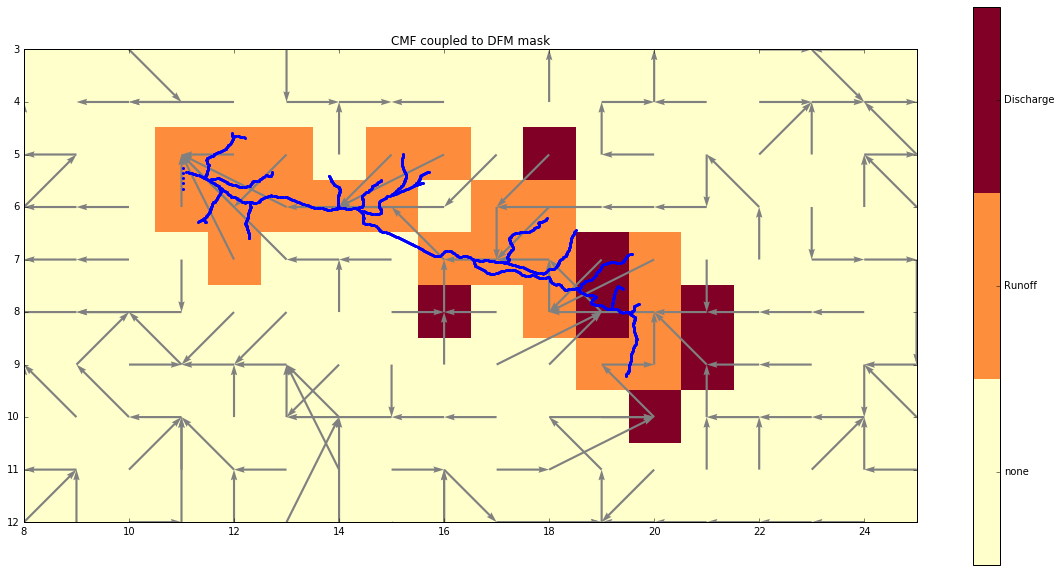

In [14]:
# get DFM 1d nodes in local grid coordinates
x, y = zip(*DFM_bmi.model_1d_coords)
c, r = ~CMF_bmi.model_grid_transform * (np.atleast_1d(x), np.atleast_1d(y))
c, r = c-0.0, r-1.0 # why this offset ??

# set colorscheme
cmap=plt.cm.YlOrRd
bounds = np.linspace(-0.5,2.5,4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# plot figure
fig = plt.figure(figsize=(20, 10))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, interpolation='nearest', cmap=cmap, norm=norm)
CMF_bmi.dd.plot_dd(ax=b, color='grey', label='CMF ldd')
b.scatter(c, r, s=4, color='b', label='DFM 1D nodes')
# fix colorbar
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['none', 'Runoff', 'Discharge'])
b.set_title('CMF coupled to DFM mask')
b.set_xlim([8, 25])
b.set_ylim([12, 3])
# plt.legend()
plt.savefig(os.path.join(out_dir,'couplingScheme.png'), dpi=600)

note there is a difference in DFM nodes and DFM coupled nodes as some are in unit catchments that are ignored by CMF. The runoff from PCR is however mass-conservative in the CMF runoff input.

In [12]:
len(DFM_bmi.model_1d_coords), len(DFM_bmi.coupled_idx)

(1428, 1425)

## initialize CMF and PCR models

In [ ]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

## define exchange of values in update states function

In [ ]:
def set_CMF_forcing():
    "coupling runoff between CMF and PCR model"
    runoff = np.nan_to_num(PCR_bmi.get_var('runoff')) # [m/day]
    # note that runoff in (roffin) should be used to set PCR runoff. 
    CMF_bmi.set_var("roffin", runoff) # [m/dtin] = [m/d]

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
CMFidx = CMF_bmi.coupled_idx
CMFfrac = CMF_bmi.coupled_area_frac

def set_DFM_forcing():
    CMF_delta_vol = CMF_bmi.get_coupled_flux() # 2d array [m3/day]
    DFM_depth_conservative = CMF_delta_vol[CMFidx] * CMFfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return CMF_delta_vol
        

## find location to record qsim from CMF on the fly

In [ ]:
#- get upsteram area at comparison point in CMF
from os.path import join
upArea = np.fromfile(join(in_dir, r'CMF_Elbe/uparea.bin'), 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [ ]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

## run coupled CMF - DFM model

In [ ]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

In [ ]:
# run for numer of timesteps specified in set-file
tStart = datetime.now()
CMF_delta_vol_temp = 0.0
DFM_Vstart = np.sum(np.copy(DFM_bmi.get_var('vol1')))
for i in range(timeSteps):
# for i in range(10):
    PCR_bmi.update()
    set_CMF_forcing()
    CMF_bmi.update()
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
    CMF_delta_vol = set_DFM_forcing()
    CMF_delta_vol_temp += np.sum(CMF_delta_vol)
    DFM_bmi.update()
tEnd = datetime.now()
# cmf_of.close()

In [ ]:
tEnd = datetime.now()
cmf_of.close()

In [ ]:
# get DFM 1d nodes in local grid coordinates
x, y = zip(*DFM_bmi.model_1d_coords) # only 1d coords
c, r = ~CMF_bmi.model_grid_transform * (np.atleast_1d(x), np.atleast_1d(y))
c, r = c-0.0, r-1.0 # why this offset ??

# set values to right index
plot_depth = np.zeros(len(r))
plot_depth[DFMidx - DFM_bmi._1d2d_idx] = DFM_bmi.get_var('s1')[DFMidx]

# plot figure
fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
im = plt.imshow(np.ma.masked_equal(CMF_bmi.get_coupled_flux(), 0), vmin=0, interpolation='nearest', cmap='Blues')
CMF_bmi.dd.plot_dd(ax=b, color='grey', label='PCR ldd')
im2 = b.scatter(c, r, s=4, c=plot_depth, cmap='YlOrRd',vmin=0) # norm=mpl.colors.LogNorm())
# fix colorbar
cbar1 = plt.colorbar(im)
cbar1.set_label('CMF flux (runoff+discharge) [m3/day]')
cbar = plt.colorbar(im2)
cbar.set_label('DFM water level [m]')
b.set_title('CMF coupled to DFM flux')
b.set_xlim([8, 25])
b.set_ylim([12, 3])

In [ ]:
runoff = np.copy(PCR_bmi.get_var('runoff'))
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = np.copy(CMF_bmi.get_var('rivsto_out'))
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [ ]:
#- reassess location of CMF output point by comparing with simulated discharge
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
test = np.copy(outflw)
test[6,13] = 1000

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(test)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [ ]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

## Finalize models

In [ ]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()

## Check water balance PCR->CMF

In [ ]:
CMF_logfile = os.path.join(CMF_out_dir, 'out/run_2000.log')
cmf_lf = open(CMF_logfile, 'r')
WB_error = float(cmf_lf.readlines()[-1].split()[-2]) * 10e9
print('Water balance error in CMF: {} m3'.format(WB_error))


## Check water balance CMF->DFM

In [ ]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract input precipitation from nc-file accumluated over time (for this run)
precip = no.variables['water_balance_precipitation']
#- select last entry
precip_tot = precip[-1]

print 'agreement of DFM input precipitation with output CMF volumes: ', precip_tot /  CMF_delta_vol_temp

## Check water balance DFM

In [ ]:
#- extract outflow accumluated over time from nc-file  (for this run)
bo_out = no.variables['water_balance_boundaries_out']
#- select last entry
bo_out = bo_out[-1]

In [ ]:
DFM_Vend = np.sum(np.copy(DFM_bmi.get_var('vol1')))
DFM_Vdiff = DFM_Vend - DFM_Vstart
print 'difference in volumes END - START: ', DFM_Vdiff, '\n'

DFM_Vdiff1 = DFM_Vdiff - CMF_delta_vol_temp
print 'remaining difference after subtracting input volume: ', DFM_Vdiff1, '\n'

DFM_Vdiff2 = DFM_Vdiff1 + bo_out
print 'remaining difference after adding DFM outflow: ', DFM_Vdiff2, '\n'

print 'fraction of remaining difference compared to overall DFM volumes: ',  np.absolute(DFM_Vdiff2) / DFM_Vend

## Compare model results

In [ ]:
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])
#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(in_dir, 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(in_dir, 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(in_dir, 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(in_dir, 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(len(qsim_ND)+1,4300, 'PCR->CMF->DFM : '+str(KGE_ND))
plt.text(len(qsim_ND)+1,4150, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(out_dir, 'compareAndvalidate_Qsim_PCR2CMF2DFM.png'), dpi=300)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(cd, 'k', label = 'PCR->CMF')
plt.plot(qsim_ND, 'r', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))